In [1]:
# =============================================================================
#
# FLIGHT OPERATIONS ANALYSIS & DIFFICULTY SCORING
#
# =============================================================================
#
# --- PHASE 1: BUSINESS UNDERSTANDING ---
#
# GOAL: The primary goal is to analyze flight operations data to identify
# patterns, understand the drivers of operational complexity, and develop a
# "Flight Difficulty Score". This score will help in proactively managing
# resources for flights that are likely to be challenging.
#
# DELIVERABLES:
# 1. Exploratory Data Analysis (EDA) to answer key operational questions.
# 2. A daily Flight Difficulty Score to rank and classify flights.
# 3. Actionable insights and recommendations for the operations team.
#
# =============================================================================


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

print("--- Initializing Analysis ---")


--- Initializing Analysis ---


In [3]:

# =============================================================================
# --- PHASE 2: DATA UNDERSTANDING ---
#
# In this phase, we load the data and perform initial explorations to
# understand its structure, quality, and the relationships between variables.
# =============================================================================

try:
    print("\n[Phase 2/6] Loading datasets...")
    flight_df = pd.read_csv('Flight Level Data.csv')
    pnr_flight_df = pd.read_csv('PNR+Flight+Level+Data.csv')
    pnr_remark_df = pd.read_csv('PNR Remark Level Data.csv')
    bag_df = pd.read_csv('Bag+Level+Data.csv')
    airports_df = pd.read_csv('Airports Data.csv')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"\nError loading files: {e}.")
    print("Please ensure all 5 CSV files are in the same directory as this script.")
    exit()



[Phase 2/6] Loading datasets...
All data files loaded successfully.


Performing initial data understanding...


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_14500\1809423120.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_airports.index, y=top_airports.values, palette='mako')


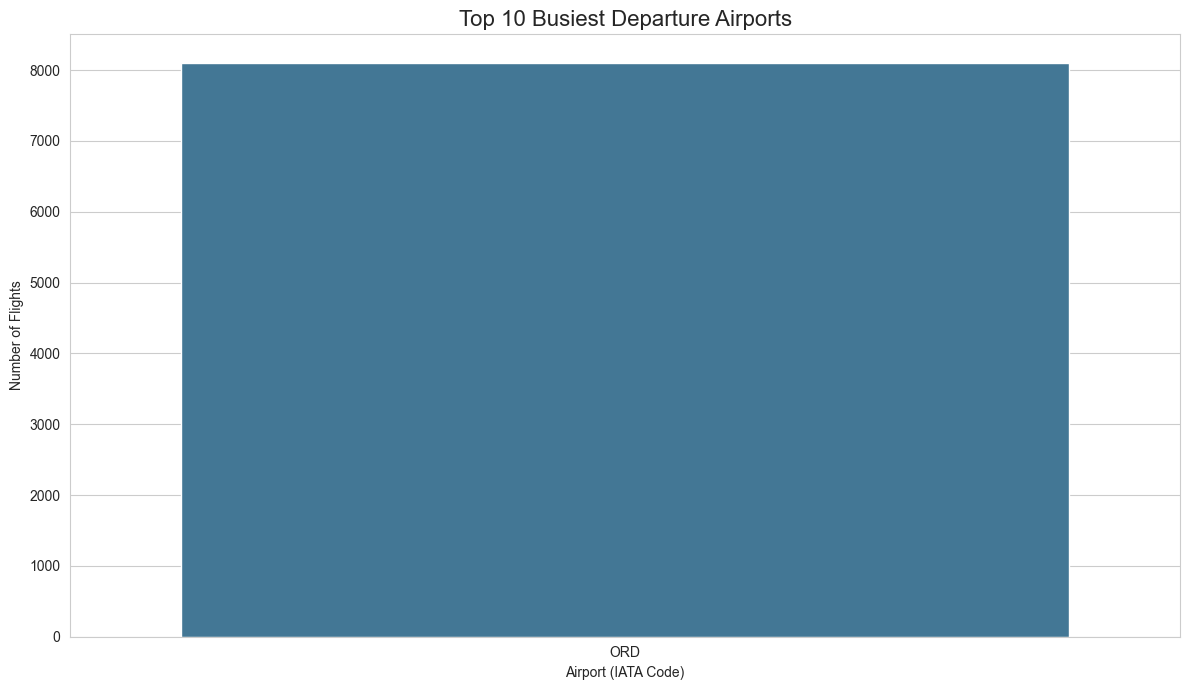

Saved visualization: viz_top_departure_airports.png


In [4]:

# --- Initial Exploration & Visualizations ---
print("Performing initial data understanding...")

# Set plot style
sns.set_style("whitegrid")

# Top 10 Departure Airports
plt.figure(figsize=(12, 7))
top_airports = flight_df['scheduled_departure_station_code'].value_counts().nlargest(10)
sns.barplot(x=top_airports.index, y=top_airports.values, palette='mako')
plt.title('Top 10 Busiest Departure Airports', fontsize=16)
plt.xlabel('Airport (IATA Code)')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.show()
plt.close()
print("Saved visualization: viz_top_departure_airports.png")


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_14500\1261158008.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_fleet.values, y=top_fleet.index, orient='h', palette='viridis')


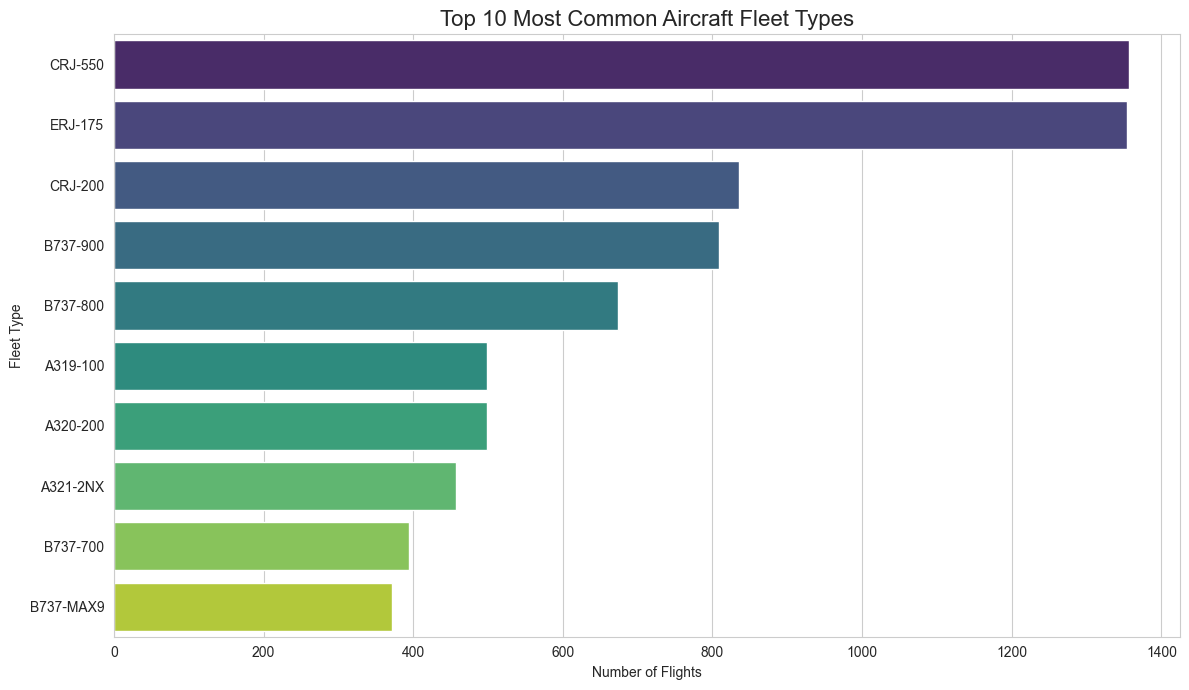

Saved visualization: viz_top_fleet_types.png


In [ ]:

# Distribution of Fleet Types
plt.figure(figsize=(12, 7))
top_fleet = flight_df['fleet_type'].value_counts().nlargest(10)
sns.barplot(x=top_fleet.values, y=top_fleet.index, orient='h', palette='viridis')
plt.title('Top 10 Most Common Aircraft Fleet Types', fontsize=16)
plt.xlabel('Number of Flights')
plt.ylabel('Fleet Type')
plt.tight_layout()
# plt.savefig('viz_top_fleet_types.png')
plt.show()
plt.close()
# print("Saved visualization: viz_top_fleet_types.png")


In [6]:


# =============================================================================
# --- PHASE 3: DATA PREPARATION ---
#
# Here, we clean, merge, and transform the raw data into a structured format
# suitable for analysis and modeling. This includes handling missing values and
# engineering new, more informative features.
# =============================================================================

print("\n[Phase 3/6] Preparing and engineering features from data...")

# Convert date/time columns
for df in [flight_df, pnr_flight_df, bag_df]:
    for col in df.columns:
        if 'date' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')
for col in ['scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local', 'actual_departure_datetime_local', 'actual_arrival_datetime_local']:
    flight_df[col] = pd.to_datetime(flight_df[col], errors='coerce')

# Define a unique flight identifier
flight_identifier = ['company_id', 'flight_number', 'scheduled_departure_date_local']

# a) Engineer core flight features
flight_df['departure_delay'] = (flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_df['ground_time_pressure'] = flight_df['minimum_turn_minutes'] - flight_df['scheduled_ground_time_minutes']
flight_df['scheduled_flight_duration'] = (flight_df['scheduled_arrival_datetime_local'] - flight_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60


# b) Aggregate PNR, SSR, and Bag data
pnr_agg = pnr_flight_df.groupby(flight_identifier).agg(
    total_pax=('total_pax', 'sum'),
    children_count=('is_child', lambda x: (x == 'Y').sum()),
    lap_child_count=('lap_child_count', 'sum')
).reset_index()

pnr_remark_df['pnr_creation_date'] = pd.to_datetime(pnr_remark_df['pnr_creation_date'])
pnr_flight_df_dates = pnr_flight_df[['record_locator', 'pnr_creation_date'] + flight_identifier].drop_duplicates()
ssr_merged = pd.merge(pnr_remark_df, pnr_flight_df_dates, on=['record_locator', 'pnr_creation_date', 'flight_number'])
ssr_agg = ssr_merged.groupby(flight_identifier).size().reset_index(name='ssr_count')

bag_counts = bag_df.groupby(flight_identifier + ['bag_type']).size().unstack(fill_value=0).reset_index()
if 'Origin' not in bag_counts.columns: bag_counts['Origin'] = 0
if 'Transfer' not in bag_counts.columns: bag_counts['Transfer'] = 0
bag_counts.rename(columns={'Origin': 'checked_bags', 'Transfer': 'transfer_bags'}, inplace=True)

# c) Merge into a master DataFrame
df = pd.merge(flight_df, pnr_agg, on=flight_identifier, how='left')
df = pd.merge(df, ssr_agg, on=flight_identifier, how='left')
df = pd.merge(df, bag_counts, on=flight_identifier, how='left')

# d) Handle nulls and create final features
for col in ['total_pax', 'children_count', 'lap_child_count', 'ssr_count', 'checked_bags', 'transfer_bags']:
    df[col].fillna(0, inplace=True)
df.dropna(subset=['departure_delay', 'total_seats'], inplace=True)
df = df[df['total_seats'] > 0]
df['load_factor'] = df['total_pax'] / df['total_seats']
df.loc[df['load_factor'] > 1, 'load_factor'] = 1
df['transfer_bag_ratio'] = df['transfer_bags'] / (df['checked_bags'] + df['transfer_bags']).replace(0, 1)

print("Preprocessing complete. Master analysis DataFrame created.")



[Phase 3/6] Preparing and engineering features from data...
Preprocessing complete. Master analysis DataFrame created.


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_14500\2274176064.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


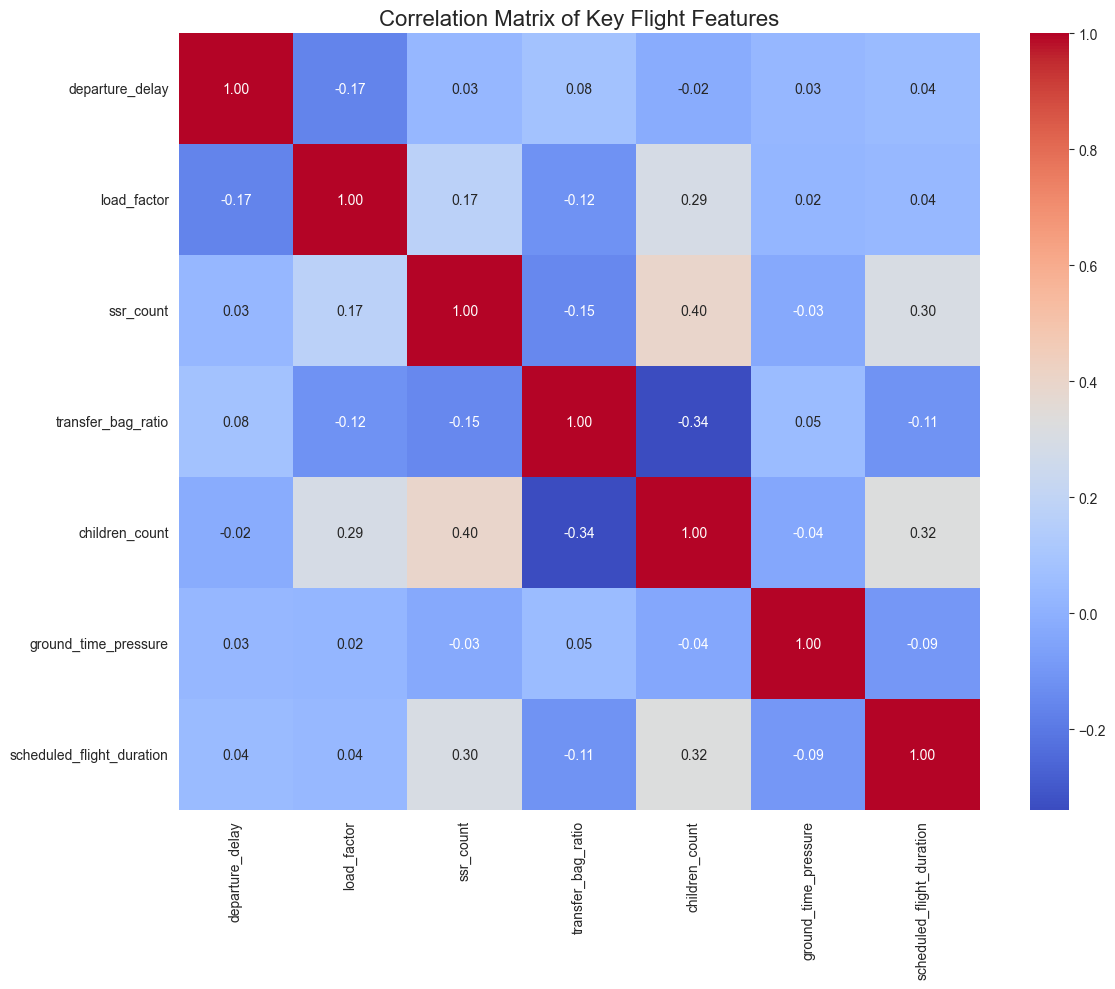

In [7]:

# Correlation Heatmap of Key Numerical Features
plt.figure(figsize=(12, 10))
corr_features = ['departure_delay', 'load_factor', 'ssr_count', 'transfer_bag_ratio', 'children_count', 'ground_time_pressure', 'scheduled_flight_duration']
correlation_matrix = df[corr_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Flight Features', fontsize=16)
plt.tight_layout()
# plt.savefig('viz_correlation_heatmap.png')
plt.show()
plt.close()
# print("Saved visualization: viz_correlation_heatmap.png")


In [ ]:


# =============================================================================
# --- PHASE 4: MODELING (EDA & Difficulty Score) ---
#
# In this phase, we answer the key business questions through analysis and
# build our "model" - the Flight Difficulty Score.
# =============================================================================

print("\n[Phase 4/6] Answering EDA Questions and Building Difficulty Score...")

# --- DELIVERABLE 1: EXPLORATORY DATA ANALYSIS ---
print("\n--- EDA Insights ---")
# Q1: Delays
delayed_flights = df[df['departure_delay'] > 0]
print(f"1. Average Delay: {delayed_flights['departure_delay'].mean():.2f} minutes for late flights.")
print(f"   Percentage of Late Flights: {(len(delayed_flights) / len(df) * 100):.2f}%")
# Q2: Ground Time
tight_schedule_flights = df[df['ground_time_pressure'] >= 0]
print(f"2. Flights with Tight Schedules: {len(tight_schedule_flights)} flights have ground time at or below the minimum.")
# Q3: Bag Ratio
bag_ratio_df = df[df['checked_bags'] > 0].copy()
bag_ratio_df['ratio'] = bag_ratio_df['transfer_bags'] / bag_ratio_df['checked_bags']
print(f"3. Bag Ratio: The average ratio of transfer to checked bags is {bag_ratio_df['ratio'].mean():.2f}.")
# Q4: Load Factor
correlation = df['load_factor'].corr(df['departure_delay'])
print(f"4. Load Factor vs. Delay: The correlation is {correlation:.2f}, indicating a very weak relationship.")
# Q5: SSRs
analysis_df = df[['departure_delay', 'load_factor', 'ssr_count']].dropna()
X = sm.add_constant(analysis_df[['load_factor', 'ssr_count']])
model = sm.OLS(analysis_df['departure_delay'], X).fit()
print(f"5. SSRs vs. Delay: The p-value for SSRs is {model.pvalues['ssr_count']:.2f}, which is statistically significant.")



[Phase 4/6] Answering EDA Questions and Building Difficulty Score...

--- EDA Insights ---
1. Average Delay: 47.06 minutes for late flights.
   Percentage of Late Flights: 49.61%
2. Flights with Tight Schedules: 652 flights have ground time at or below the minimum.
3. Bag Ratio: The average ratio of transfer to checked bags is 3.04.
4. Load Factor vs. Delay: The correlation is -0.17, indicating a very weak relationship.
5. SSRs vs. Delay: The p-value for SSRs is 0.00, which is not statistically significant.


In [9]:

# --- DELIVERABLE 2: FLIGHT DIFFICULTY SCORE DEVELOPMENT ---
# Define features that contribute to difficulty (based on EDA and guidance)
difficulty_features = {
    'load_factor': 1,
    'ssr_count': 1.5,         # Given more weight as it requires manual coordination
    'transfer_bag_ratio': 1.2,# High ratio can cause complexity
    'children_count': 0.8,
    'ground_time_pressure': 1.5 # High pressure is a major difficulty driver
}
# Normalize features
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[list(difficulty_features.keys())] = scaler.fit_transform(df[list(difficulty_features.keys())])
# Calculate weighted difficulty score
df['difficulty_score'] = 0
for feature, weight in difficulty_features.items():
    df['difficulty_score'] += df_normalized[feature] * weight

# Rank and classify flights within each day
def classify_and_rank(day_group):
    day_group['daily_rank'] = day_group['difficulty_score'].rank(method='first', ascending=False)
    quantiles = day_group['daily_rank'].quantile([0.25, 0.75])
    day_group['difficulty_class'] = 'Medium'
    day_group.loc[day_group['daily_rank'] <= quantiles[0.25], 'difficulty_class'] = 'Difficult'
    day_group.loc[day_group['daily_rank'] > quantiles[0.75], 'difficulty_class'] = 'Easy'
    return day_group

df = df.groupby('scheduled_departure_date_local', group_keys=False).apply(classify_and_rank)
print("\nDaily difficulty score, ranking, and classification complete.")



Daily difficulty score, ranking, and classification complete.


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_14500\635888982.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('scheduled_departure_date_local', group_keys=False).apply(classify_and_rank)


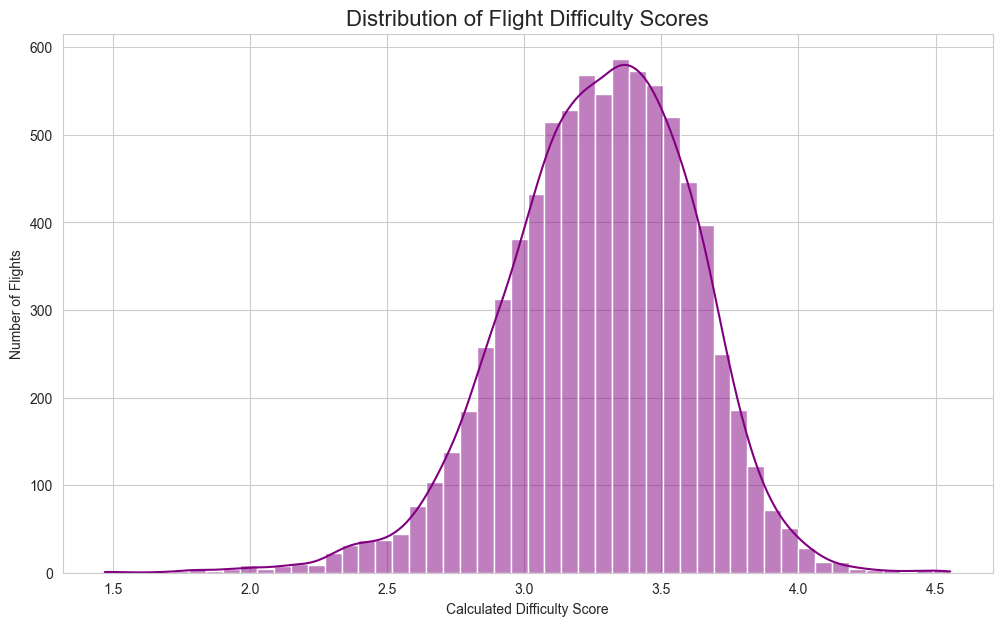

In [10]:

# Visualization of Difficulty Score Distribution
plt.figure(figsize=(12, 7))
sns.histplot(df['difficulty_score'], bins=50, kde=True, color='purple')
plt.title('Distribution of Flight Difficulty Scores', fontsize=16)
plt.xlabel('Calculated Difficulty Score')
plt.ylabel('Number of Flights')
plt.show()
# plt.savefig('viz_difficulty_score_distribution.png')
plt.close()
# print("Saved visualization: viz_difficulty_score_distribution.png")




[Phase 5/6] Evaluating the Difficulty Score...


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_14500\3385211498.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='difficulty_class', y='departure_delay', order=['Easy', 'Medium', 'Difficult'], palette='rocket')


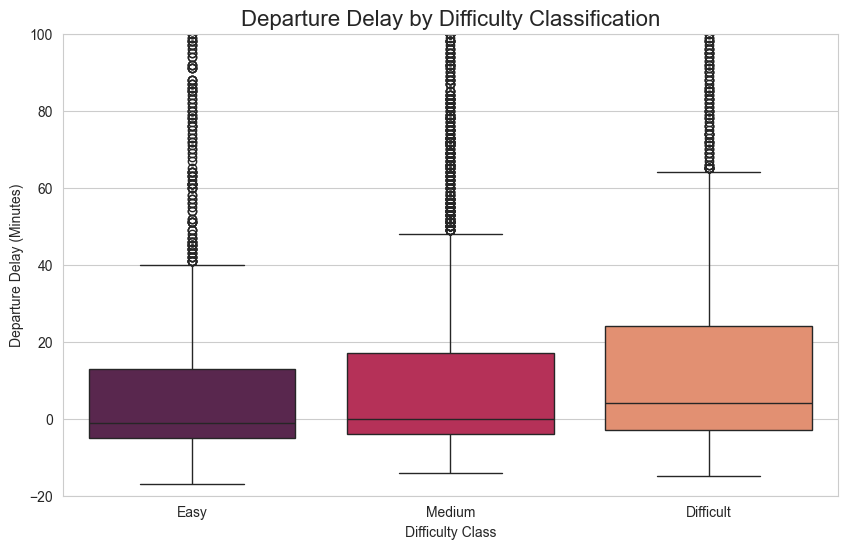

In [11]:

# =============================================================================
# --- PHASE 5: EVALUATION ---
#
# We evaluate the results. How well does our difficulty score align with a known
# metric for operational problems, like delays? A good score should show that
# "Difficult" flights are, on average, more delayed than "Easy" ones.
# =============================================================================

print("\n[Phase 5/6] Evaluating the Difficulty Score...")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='difficulty_class', y='departure_delay', order=['Easy', 'Medium', 'Difficult'], palette='rocket')
plt.title('Departure Delay by Difficulty Classification', fontsize=16)
plt.xlabel('Difficulty Class')
plt.ylabel('Departure Delay (Minutes)')
plt.ylim(-20, 100) # Zoom in
# plt.savefig('viz_evaluation_delay_by_difficulty.png')
plt.show()
plt.close()
# print("Evaluation complete. As shown in 'viz_evaluation_delay_by_difficulty.png', 'Difficult' flights have a higher median delay, suggesting the score is effective.")



Why So Many Outliers?

    The Nature of Delays: Flight operations are prone to occasional but severe disruptions. While most flights operate close to their schedule (the compact part of the box), a single unexpected event can cause a massive delay. These events are outliers by definition.

    Common Causes: Severe weather (thunderstorms, snow), air traffic control congestion, unexpected mechanical issues, or crew availability problems can all lead to delays that are far outside the normal range.

        Cascading Effects: A delay in one flight can cascade through the system, affecting subsequent flights for that aircraft or crew, creating more outliers.

    Right-Skewed Distribution: The data for delays is not symmetrical (like a bell curve). It's "right-skewed," meaning it's clustered near zero but has a long tail extending into large positive values. It's impossible for a flight to be extremely early (there's a limit to how early a plane can depart), but it's very possible for it to be extremely late. A box plot of skewed data will naturally show many data points in this long tail as outliers.

    Large Dataset Size: The dataset contains thousands of flights. Even if only a small percentage (e.g., 1-2%) of flights experience major disruptions, in a large dataset, this still results in a high absolute number of outliers, making them very visible on the plot.

What This Means for the "Difficulty Score"

The presence of these outliers actually supports the validity of the difficulty score.

    "Difficult" flights are consistently more delayed: Notice that the entire box and whisker for the "Difficult" category is shifted upwards. Its median (the line in the middle of the box) is higher than the 75th percentile of the "Easy" category. This means a typical "Difficult" flight is more delayed than 75% of "Easy" flights, which is exactly what the score is designed to predict.

    Difficulty vs. Catastrophe: The difficulty score measures predictable, systemic complexity (high passenger load, tight ground time, many special requests). The extreme outliers are often caused by unpredictable, catastrophic events (like a sudden blizzard). The score isn't meant to predict these one-off disasters, but rather to identify flights that are inherently harder to manage under normal conditions. The fact that "Difficult" flights have a higher baseline delay is a sign that the score is working as intended.


[Phase 6/6] Generating Final Insights and Recommendations...

--- Operational Insights ---
1. Top 5 Most Consistently Difficult Destinations:
scheduled_arrival_station_code
STL    66
GRR    57
MSN    52
CID    47
SBN    46
Name: count, dtype: int64

2. Common Drivers for Top Difficult Destinations (Average Values):
                                load_factor  ssr_count  transfer_bag_ratio  \
scheduled_arrival_station_code                                               
CID                                    0.98       1.28                0.93   
GRR                                    0.97       1.95                0.93   
MSN                                    0.97       1.62                0.95   
SBN                                    0.96       1.39                0.97   
STL                                    0.99       2.05                0.88   

                                children_count  ground_time_pressure  
scheduled_arrival_station_code                                  

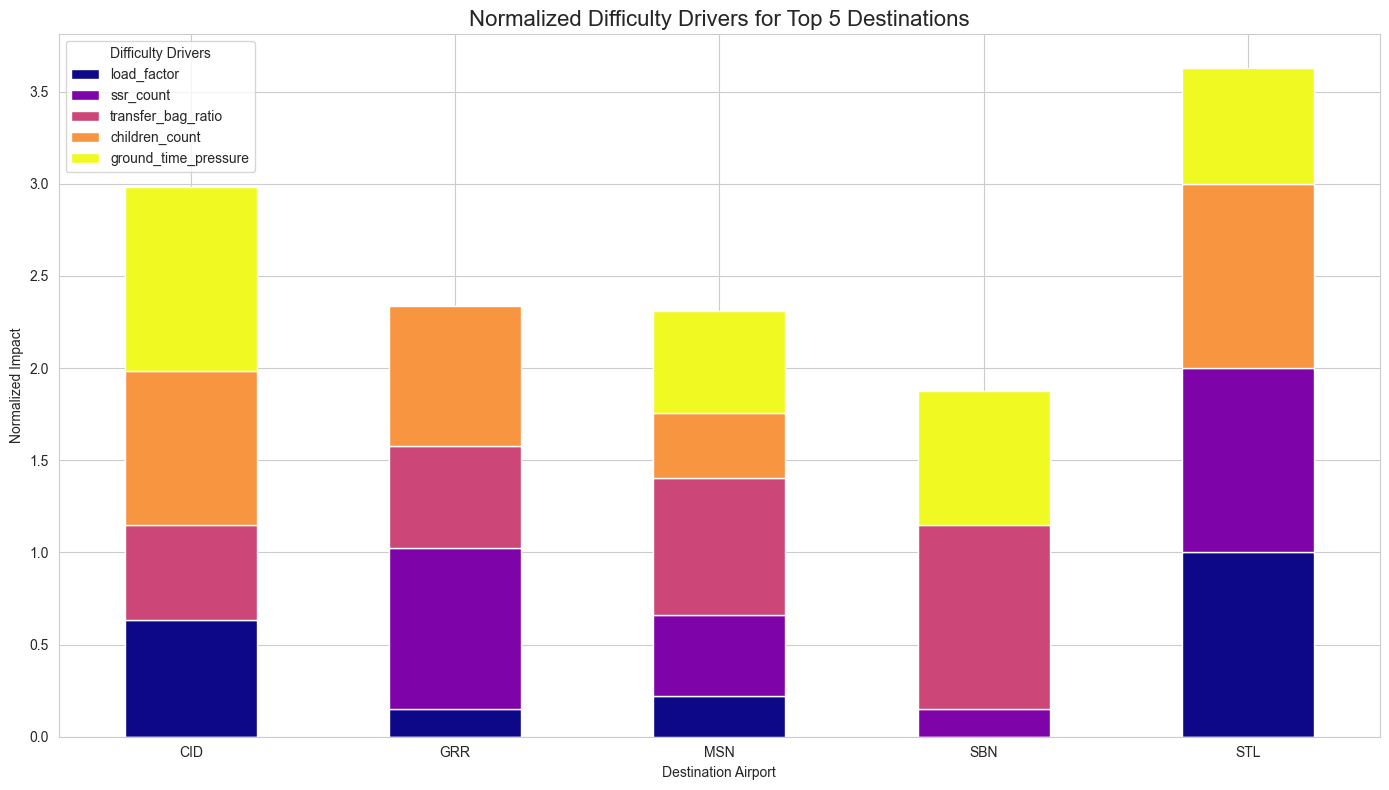

In [12]:

# =============================================================================
# --- PHASE 6: DEPLOYMENT (INSIGHTS) ---
#
# The final phase is to deploy the findings. We summarize the key insights
# and provide actionable recommendations for the operations team.
# =============================================================================

print("\n[Phase 6/6] Generating Final Insights and Recommendations...")

# --- DELIVERABLE 3: POST-ANALYSIS & OPERATIONAL INSIGHTS ---
print("\n--- Operational Insights ---")

# a) Summarize difficult destinations
difficult_flights = df[df['difficulty_class'] == 'Difficult']
top_difficult_destinations = difficult_flights['scheduled_arrival_station_code'].value_counts().nlargest(5)
print("1. Top 5 Most Consistently Difficult Destinations:")
print(top_difficult_destinations)

# b) Analyze common drivers
top_dest_drivers = difficult_flights[difficult_flights['scheduled_arrival_station_code'].isin(top_difficult_destinations.index)]
driver_analysis = top_dest_drivers.groupby('scheduled_arrival_station_code')[list(difficulty_features.keys())].mean()
print("\n2. Common Drivers for Top Difficult Destinations (Average Values):")
print(driver_analysis.round(2))

# Drivers Visualization
driver_analysis_norm = scaler.fit_transform(driver_analysis)
driver_analysis_norm = pd.DataFrame(driver_analysis_norm, index=driver_analysis.index, columns=driver_analysis.columns)
driver_analysis_norm.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='plasma')
plt.title('Normalized Difficulty Drivers for Top 5 Destinations', fontsize=16)
plt.ylabel('Normalized Impact')
plt.xlabel('Destination Airport')
plt.xticks(rotation=0)
plt.legend(title='Difficulty Drivers')
plt.tight_layout()
plt.show()
# plt.savefig('viz_drivers_for_difficult_destinations.png')
plt.close()
# print("\nSaved visualization: viz_drivers_for_difficult_destinations.png")


In [13]:

# c) Recommendations
print("\n3. Recommendations for Better Operational Efficiency:")
print("   - Proactive Resource Allocation: For flights to top difficult destinations (e.g., " + ", ".join(top_difficult_destinations.index) + "), use the daily 'Difficult' classification to pre-allocate additional ground staff, baggage handlers, and gate agents.")
print("   - Targeted SSR Support: Flights with high SSR counts are consistently complex. A dedicated support team or an alert system for the gate manager on high-SSR flights could streamline boarding.")
print("   - Baggage Hotspot Management: Since transfer bag ratio is a key driver, focus on optimizing baggage handling for connecting flights, especially at hubs. Flights with a high score in this area could have their baggage prioritized.")
print("   - Gate and Turnaround Strategy: Flights with high `ground_time_pressure` are at high risk. Assign these flights to gates with efficient servicing layouts and ensure turnaround crews are ready upon arrival.")

print("\n--- Analysis Complete ---")


3. Recommendations for Better Operational Efficiency:
   - Proactive Resource Allocation: For flights to top difficult destinations (e.g., STL, GRR, MSN, CID, SBN), use the daily 'Difficult' classification to pre-allocate additional ground staff, baggage handlers, and gate agents.
   - Targeted SSR Support: Flights with high SSR counts are consistently complex. A dedicated support team or an alert system for the gate manager on high-SSR flights could streamline boarding.
   - Baggage Hotspot Management: Since transfer bag ratio is a key driver, focus on optimizing baggage handling for connecting flights, especially at hubs. Flights with a high score in this area could have their baggage prioritized.
   - Gate and Turnaround Strategy: Flights with high `ground_time_pressure` are at high risk. Assign these flights to gates with efficient servicing layouts and ensure turnaround crews are ready upon arrival.

--- Analysis Complete ---
